## E796: CNN for event classification

### Reading the data with pyROOT

In [1]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample, shuffle
import utils

<BarContainer object of 2 artists>

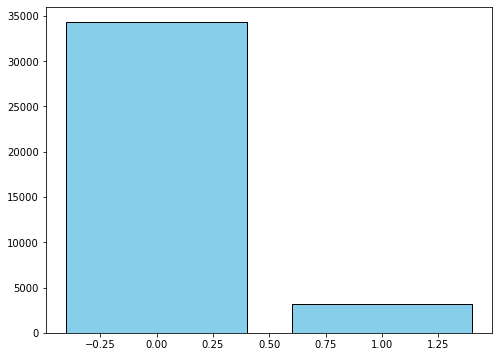

In [2]:
data, labels = utils.ReadROOTFile('dataset.root')

# Declare projection size
grid_size = 128

# Plot distribution of labels
unique_labels, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(unique_labels, counts, color='skyblue', edgecolor='black')

In [4]:
# Get the data properly shape
grid = utils.TransformData(data, grid_size)

In [13]:
labels = labels.astype(int)


In [3]:
#Select events

zeros = xy[labels == 0]
ones = xy[labels == 1]

zeros_downscaled = resample(zeros, replace=False, n_samples=len(ones), random_state=42)

xy_downscaled = np.vstack((zeros_downscaled, ones))
labels_downscaled = np.hstack((np.zeros(len(zeros_downscaled)), np.ones(len(ones))))

In [4]:
# And shuffle events
xy_suffled, labels_shuffled = shuffle(xy_downscaled, labels_downscaled, random_state=42)

# Build dense data
nentries = len(xy_suffled)
grid_size = 128
grid = np.zeros((nentries, grid_size, grid_size), dtype=int)
for row, sparse in enumerate(xy_suffled):
    for i,j in zip(sparse[0], sparse[1]):
            grid[row, i,j] = 1

# And add grayscale as last axis
grid_ok = grid.reshape(-1, grid_size, grid_size, 1)
labels_ok = labels_shuffled

### Building the CNN model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten

2025-01-27 20:53:12.794022: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 20:53:12.794435: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 20:53:12.797564: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 20:53:12.825711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 20:53:13.417377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [7]:
model = Sequential([
    Input(shape=(grid_size, grid_size, 1)),
    Conv2D(128, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (2,2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,129 (781.75 KB)

 Trainable params: 200,129 (781.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# And train!
history = model.fit(grid, labels, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 575s 306ms/step - accuracy: 0.8873 - loss: 2.7456 - val_accuracy: 0.9164 - val_loss: 0.2874
Epoch 2/10
1563/1876 ━━━━━━━━━━━━━━━━━━━━ 1:24 269ms/step - accuracy: 0.9178 - loss: 0.2824

KeyboardInterrupt: 

NameError: name 'history' is not defined

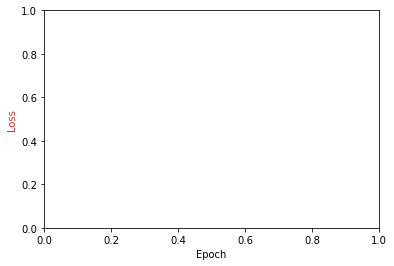

In [15]:
# Plotting both loss and accuracy in one plot
fig, ax1 = plt.subplots()

# Plot loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], label='Training Loss', color='tab:red')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis to plot accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='tab:blue')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Adding a title and legends
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
